## Yield Spread model
This notebook implements a model to predict yield spreads from reference and trade history data. 

Last modification: After observing the largest errors, we add s condition to the query for the duration elapsed between the current trade and last trade. Currently set to 12 days 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS
from ficc.utils.gcp_storage_functions import upload_data, download_data
from tfidf_features import get_tfidf_features

Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Setting the seed for layer initializer. We want the layers to be initialized with the same values to make the experiments deterministic

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="eng-reactor-287421-112eb767e1b3.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [4]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Initializing Wandb

In [7]:
# wandb.init(project="yield_spread_model", entity="ficc-ai", name="yield_spread_DDDSDP_no_vol")

#### Query to fetch data

We create the training data from the trades which occured between July and October in 2021. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds whose yield is a positive number less than three. The matrurity description code is restricted to 2 to remove all muni derivaties.



In [9]:
DATA_QUERY = ''' 
SELECT
  *
FROM
  `eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0
  AND par_traded >= 10000
  AND trade_date >= '2021-08-01'
  AND trade_date <= '2022-03-23'
  AND maturity_description_code = 2
  AND coupon_type in (8, 4, 10)
  AND capital_type <> 10
  AND default_exists <> TRUE
  AND sale_type <> 4
  AND sec_regulation IS NULL
  AND most_recent_default_event IS NULL
  AND default_indicator IS FALSE
  AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_datetime DESC ''' 

In [10]:
# DATA_QUERY = ''' 
# SELECT
#   *
# FROM
#   `eng-reactor-287421.auxiliary_views.materialized_trade_history`
# WHERE
#   yield IS NOT NULL
#   AND yield > 0
#   AND par_traded >= 10000
#   AND trade_date >= '2021-08-01'
#   AND trade_date <= '2022-03-23'
#   AND maturity_description_code = 2
#   AND (coupon_type = 8 OR coupon_type = 4 OR coupon_type = 10)
#   AND capital_type <> 10
#   AND default_exists <> TRUE
#   AND sale_type <> 4
#   AND sec_regulation IS NULL
#   AND most_recent_default_event IS NULL
#   AND default_indicator IS FALSE
#   AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
#   AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
#   AND (purpose_sub_class is null or 
#        purpose_sub_class <> 6 or 
#        purpose_sub_class <> 20 or 
#        purpose_sub_class <> 21 or 
#        purpose_sub_class <> 22 or 
#        purpose_sub_class <> 57 or 
#        purpose_sub_class <> 44 or 
#        purpose_sub_class <> 106)
#  AND (called_redemption_type is null or called_redemption_type <> 18 or called_redemption_type <> 19)
# ORDER BY
#   trade_datetime DESC ''' 

#### Data Preparation
We grab the data from BigQuery and converts it into a format suitable for input to the model. We save the processed data as a pickle file. If the file already exists we read it from the file. 

The remove_trade_type array contains the trade type that we want to remove from the history. The dealer dealer pickle only contains dealer dealer trades in the trade history

In [11]:
# processed_file = 'processed_data_all_hist_seconds_ago_condition.pkl'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H:%M')
# processed_file = f"processed_data_ficc_one_trade_hist_{file_timestamp}.pkl"
processed_file = "processed_data_ficc_one_trade_hist_2022-04-05-16_37.pkl"

In [12]:
processed_file

'processed_data_ficc_one_trade_hist_2022-04-05-16_37.pkl'

In [13]:
%%time
if not os.path.isfile(processed_file):
    data = process_data(DATA_QUERY, 
                        bq_client,
                        SEQUENCE_LENGTH,
                        NUM_FEATURES,
                        f"raw_data_{file_timestamp}.pkl",
                        'FICC',
                        estimate_calc_date=False,
                        remove_short_maturity=True,
                        remove_non_transaction_based=False,
                        remove_trade_type = [],
                        trade_history_delay = 1,
                        min_trades_in_history = 1,
                        process_ratings=False)
                        
    data.to_pickle(processed_file)
    upload_data(storage_client, 'ficc_models_training_data', processed_file)
    #upload_data(storage_client, 'ficc_models_training_data', "raw_data_2021_2022_feb_2022-03-08-18:06.pkl")
else:
    print('Reading from processed file')
    data = pd.read_pickle(processed_file)


Reading from processed file
CPU times: user 1min 59s, sys: 21.7 s, total: 2min 21s
Wall time: 2min 21s


In [14]:
data.purpose_sub_class.fillna(0, inplace=True)

In [15]:
# data = data[~data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 106])]

In [16]:
# data = data[~data.called_redemption_type.isin([18, 19])]

The categorical featue were adding noise to the results. Commented for now

In [17]:
# %%time
# security_description_vectorized = get_tfidf_features(data,'security_description',top_words=1000)

Creating Tf-Idf features for orginization primary name

In [18]:
# organization_primary_vectorized = get_tfidf_features(data,'organization_primary_name',top_words=1000)

In [19]:
# organization_primary_vectorized.shape

Creating binary features for the 100 most common words in the security description

In [20]:
# swords = data.security_description.str.split(expand=True).stack().value_counts()[100:].index

In [21]:
# data['set_security_descrip'] = data.security_description.apply(lambda x: set(x.split())) - set(swords)


In [22]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# binary_features_df = pd.DataFrame(mlb.fit_transform(data.set_security_descrip),columns=mlb.classes_,index=data.index)

In [23]:
# data = pd.concat([data,binary_features_df], axis = 1)

Selecting a subset of features that will be used to train on.

In [24]:
# data[data.interest_payment_frequency == 'Interest at maturity']

In [80]:
processed_data = data[IDENTIFIERS + PREDICTORS + ['calc_date', 'trade_date', 'purpose_sub_class', 'called_redemption_type', 'calc_day_cat']] #['organization_primary_name', 'security_description']]# + list(binary_features_df.columns)]

In [81]:
# BINARY = BINARY + list(binary_features_df.columns)

The process data only removes Dealer-purchase and Dealer-Sell from history. Only Selecting Dealer-Dealer trades as the trade that we want to predict the yield spread for.

In [82]:
# processed_data = processed_data[(processed_data.trade_type == 'D')]

Sanity check on trade type

In [83]:
np.unique(processed_data.trade_type)

array(['D', 'P', 'S'], dtype=object)

In [84]:
# processed_data = processed_data[processed_data.rating.isin(['BBB+','A-','A','A+','AA-','AA','AA+','AAA'])]

In [85]:
np.unique(processed_data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'CCC+', 'CCC-', 'MR',
       'NR'], dtype=object)

In [86]:
processed_data = processed_data[~processed_data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]

In [87]:
processed_data = processed_data[~processed_data.called_redemption_type.isin([18, 19])]

In [88]:
len(processed_data)

2126847

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [89]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

#### Splitting the data into train and test sets



In [90]:
train_dataframe = processed_data[processed_data.trade_date < '04-01-2022']

In [91]:
test_dataframe = processed_data[processed_data.trade_date >= '04-01-2022']

In [92]:
# train_index = int(len(processed_data) * (1-TRAIN_TEST_SPLIT))
# train_dataframe = processed_data[train_index:]
# # train_security_descrip = security_description_vectorized[train_index:]
# # train_org_primary = organization_primary_vectorized[train_index:]

# test_dataframe = processed_data[:train_index]
# # test_security_descrip = security_description_vectorized[:train_index]
# # test_org_primary = organization_primary_vectorized[:train_index]
# print(f'Print length of training data frame {len(train_dataframe)}')
# print(f'Pring length of testing data frame {len(test_dataframe)}')

In [93]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    
    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [112]:
%%time
x_train = create_input(train_dataframe)
y_train = np.stack(train_dataframe.apply(lambda x: [x.yield_spread, x.calc_day_cat], axis=1))

CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 20s


In [95]:
# x_train.append(train_security_descrip)
# x_train.append(train_org_primary)

In [162]:
%%time
x_test = create_input(test_dataframe)
# x_test.append(test_security_descrip)
# x_test.append(test_org_primary)
y_test = np.stack(test_dataframe .apply(lambda x: [x.yield_spread, x.calc_day_cat], axis=1))

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.43 s


#### Adapting Normalization layers to the non categorical features

In [115]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization()
trade_history_normalizer.adapt(x_train[0])

In [116]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization()
noncat_binary_normalizer.adapt(x_train[1])

#### Self attention layer

In [117]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth) 
        self.wk = layers.Dense(depth)
        self.wv = layers.Dense(depth)

    def scaled_dot_product_attention(self, q, k, v):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v):
        k = tf.identity(v)
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)
        
        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Defining a custom loss function

In [153]:
def custom_loss(y_true, y_preds):
    logits = y_preds[:, :4]
    predicted_ys = y_preds[:, 4]

    true_ys = y_true[:, 0]
    true_calc_date = y_true[:, 1]
    
    mae_loss = K.mean(K.abs(predicted_ys - true_ys))
    cross_entropy_loss = K.sparse_categorical_crossentropy(true_calc_date, logits, from_logits=True)
    
    loss = mae_loss + 50 * cross_entropy_loss

    return loss
    

#### Implementation of the model

In [154]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

inputs.append(trade_history_input)
inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[1]))
####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

# lstm_attention_layer = layers.Attention(use_scale=True, name='attention_layer_1')
lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')

lstm_attention_layer_2 = layers.Attention(use_scale= False, name='attention_layer_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
# features = lstm_attention_layer([features, features])
features = lstm_attention_layer(features, features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
# features = lstm_attention_layer_2([features, features])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = 15,
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)


# security_descrip_input = layers.Input(shape=(len(security_description_vectorized[0]),), name='security_descrip_input')
# inputs.append(security_descrip_input)
# security_embedd = layers.Dense(15,activation='relu',kernel_initializer=layer_initializer,name='security_descrip_shape')(security_descrip_input)
# layer.append(security_embedd)

# org_primary_input = layers.Input(shape=(len(organization_primary_vectorized[0]),), name='org_primary_input')
# inputs.append(org_primary_input)
# org_primary_embed = layers.Dense(15,activation='relu',kernel_initializer=layer_initializer,name='org_primary_embed')(org_primary_input)
# layer.append(org_primary_embed)
    
reference_hidden = layers.Dense(400,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer,name='reference_hidden_3')(reference_hidden2)

####################################################


feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu',kernel_initializer=layer_initializer)(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(5,kernel_initializer=layer_initializer)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [155]:
# model.summary()

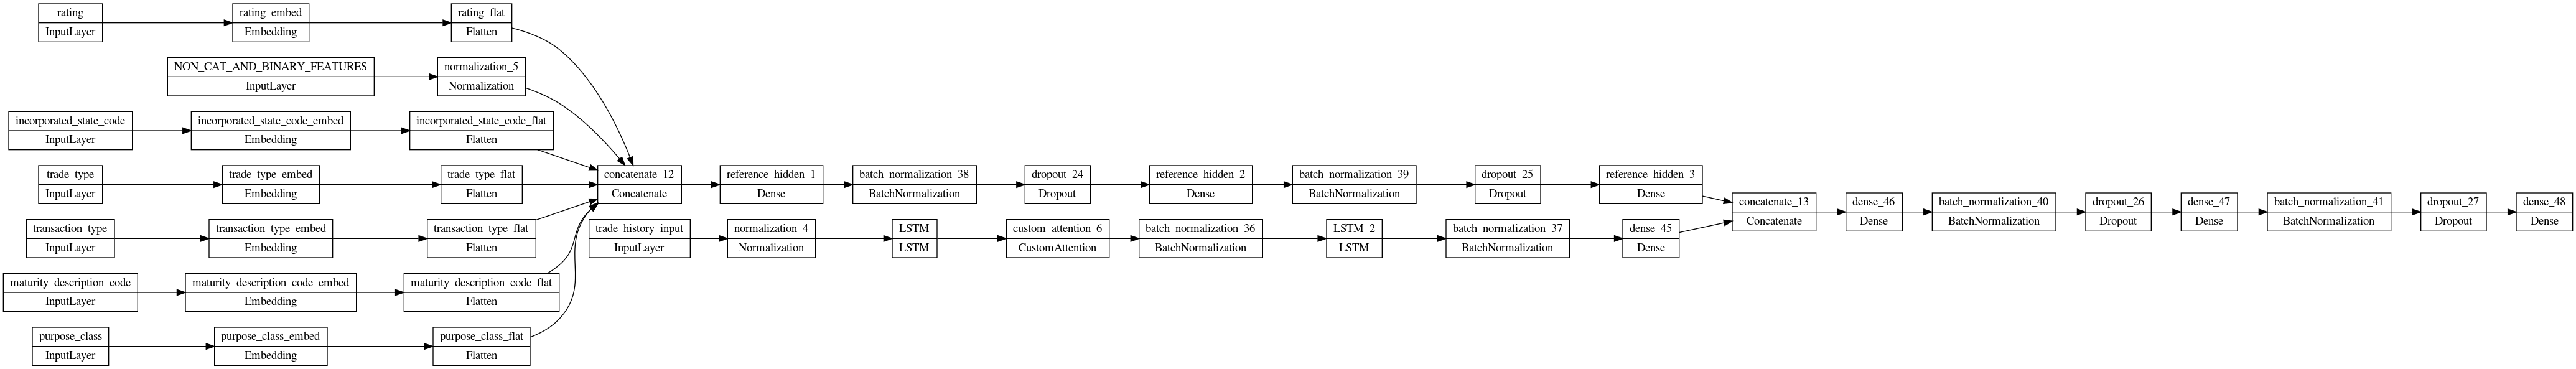

In [156]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [157]:
fit_callbacks = [
#     WandbCallback(),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    )
]

In [159]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=custom_loss,
          metrics=[custom_loss])

In [160]:
%time history = model.fit(x_train,y_train,epochs=50,batch_size=BATCH_SIZE,verbose=1,validation_split=0.1,callbacks=fit_callbacks)

Epoch 1/50
1865/1865 [==============================] - 27s 12ms/step - loss: 54.9089 - custom_loss: 54.9089 - val_loss: 50.3716 - val_custom_loss: 50.3716
Epoch 2/50
1865/1865 [==============================] - 22s 12ms/step - loss: 42.8930 - custom_loss: 42.8930 - val_loss: 32.4107 - val_custom_loss: 32.4107
Epoch 3/50
1865/1865 [==============================] - 22s 12ms/step - loss: 23.8198 - custom_loss: 23.8198 - val_loss: 14.7741 - val_custom_loss: 14.7741
Epoch 4/50
1865/1865 [==============================] - 22s 12ms/step - loss: 13.2518 - custom_loss: 13.2518 - val_loss: 10.7563 - val_custom_loss: 10.7563
Epoch 5/50
1865/1865 [==============================] - 22s 12ms/step - loss: 12.0215 - custom_loss: 12.0215 - val_loss: 10.6882 - val_custom_loss: 10.6882
Epoch 6/50
1865/1865 [==============================] - 22s 12ms/step - loss: 11.6129 - custom_loss: 11.6129 - val_loss: 9.7382 - val_custom_loss: 9.7382
Epoch 7/50
1865/1865 [==============================] - 22s 12ms/s

### Test accuracy on the entire test set

In [167]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {round(mae, 3)}")

1739/1739 [==============================] - 7s 4ms/step - loss: 14.8686 - custom_loss: 14.8686
Test loss: 14.869


## Only yield spread accuracy

In [168]:
preds = model.predict(x_test)

In [174]:
np.mean(np.abs(preds[:,4] - y_test[:,0]))

11.472401252758653

### Test accuracy on true mid

In [175]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000)) & (test_dataframe.days_to_call >= np.log10(365))]

In [176]:
len(true_mid)

422

In [178]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = np.stack(true_mid .apply(lambda x: [x.yield_spread, x.calc_day_cat], axis=1))

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 14.3 ms


In [180]:
preds = model.predict(x_true_mid)

In [181]:
np.mean(np.abs(preds[:,4] - y_true_mid[:,0]))

5.146859940079397

## Saving the model

In [186]:
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')

In [187]:
file_timestamp

'2022-04-06-20-52'

In [188]:
with open(f"encoders_{file_timestamp}.pkl"ls,'wb') as file:
    pickle.dump(encoders,file)

In [197]:
model.save(f"saved_model_{file_timestamp}")

INFO:tensorflow:Assets written to: saved_model_2022-04-06-20-52/assets


INFO:tensorflow:Assets written to: saved_model_2022-04-06-20-52/assets


In [198]:
import shutil
shutil.make_archive(f"model_{file_timestamp}", 'zip', f"saved_model_{file_timestamp}")

'/home/shayaan/ficc/ml_models/sequence_predictors/model_2022-04-06-20-52.zip'

In [201]:
upload_data(storage_client, 'ficc_encoders', f"encoders_{file_timestamp}.pkl")

File encoders_2022-04-06-20-52.pkl uploaded to ficc_encoders.


In [202]:
upload_data(storage_client, 'ficc_encoders', f"model_{file_timestamp}.zip")

File model_2022-04-06-20-52.zip uploaded to ficc_encoders.


#### Plotting validation loss vs training loss

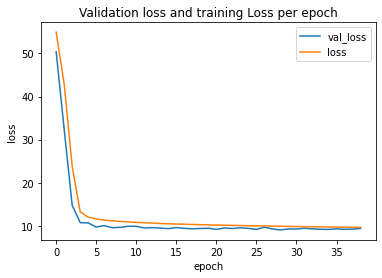

In [203]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Baseline using the last yield spread

19.030693002604423


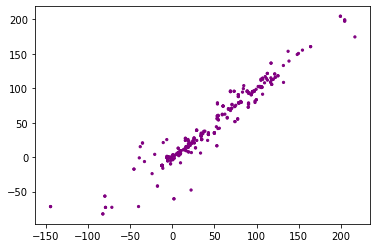

In [210]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread on dealer dealer true mid trades

19.030693002604423


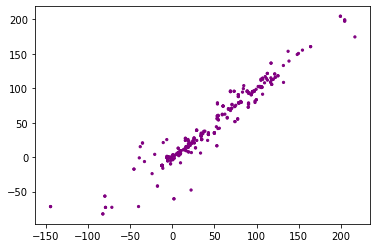

In [211]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

### Regression baseline using previous yield spread optimizing MSE

In [212]:
from sklearn.linear_model import LinearRegression

In [213]:
x = train_dataframe.last_yield_spread.values.reshape(-1,1)
y = train_dataframe.yield_spread

In [214]:
reg = LinearRegression().fit(x, y)

In [215]:
print(f"Regression coefficient {reg.coef_} Intercept {reg.intercept_}")

Regression coefficient [0.75950824] Intercept 9.645201344703892


In [216]:
predicted_ys = reg.predict(test_dataframe.last_yield_spread.values.reshape(-1,1))
actual_ys = test_dataframe.yield_spread.values

In [217]:
MAE = np.mean(np.abs(test_dataframe.yield_spread - predicted_ys))
print(MAE)

19.188270781095145


In [218]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()
y_regression = reg.coef_ * x_range + reg.intercept_

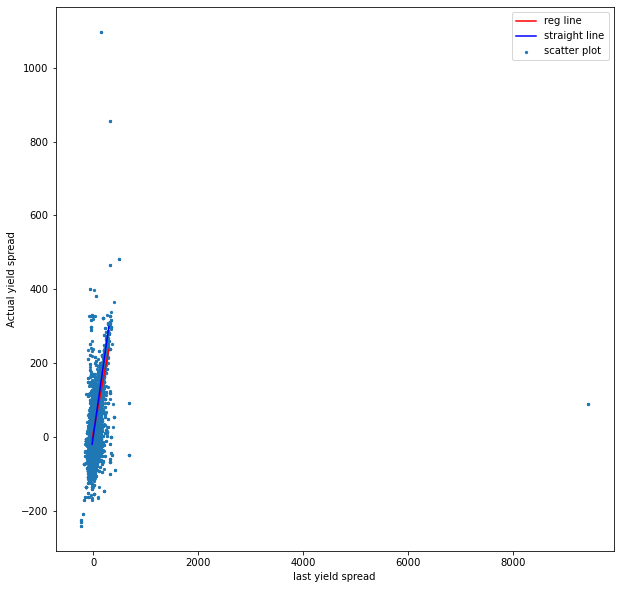

In [219]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_ys, s=5)
plt.plot(x_range, y_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('Actual yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

In [220]:
test_dataframe[test_dataframe.yield_spread > 1000][['cusip','trade_date','purpose_sub_class','yield_spread']]

,cusip,trade_date,purpose_sub_class,yield_spread
20552,646136J85,2022-04-04,17.0,1096.987447
20553,646136J85,2022-04-04,17.0,1096.987447


### Regression baseline using previous yield spread optimizing MAE

In [221]:
from statsmodels.regression.quantile_regression import QuantReg

In [222]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [223]:
res = q_reg.fit(q=.5)

In [224]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yiels_spread = test_dataframe.yield_spread.values

In [225]:
MAE = np.mean(np.abs(actual_yiels_spread - predicted_yield_spread))
print(MAE)

19.030696427720766


In [226]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 1.000000149884922


In [227]:
y_mae_regression = res.params[0] * x_range

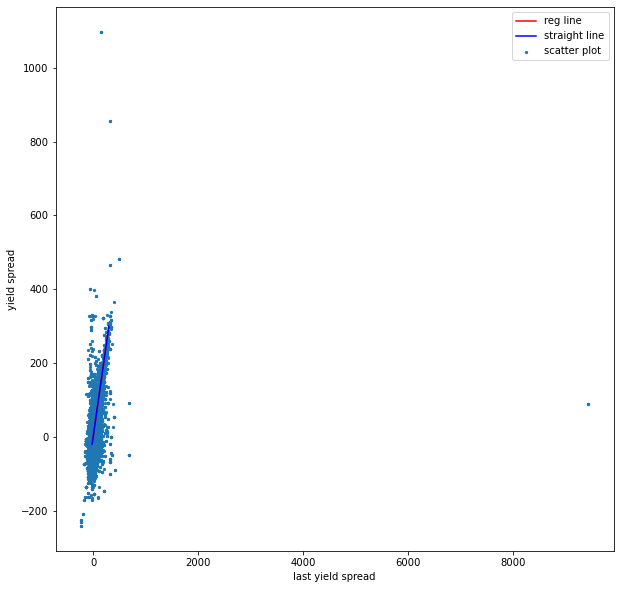

In [228]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_yiels_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

### LightGBM baseline

In [229]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','yield_spread','calc_date','trade_date'] + IDENTIFIERS)
    return df

In [230]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [231]:
gbt_td = gbmprep(train_dataframe)

In [232]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [233]:
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [234]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

-5.0414241948992125 12.904322019953742
CPU times: user 4.41 s, sys: 0 ns, total: 4.41 s
Wall time: 184 ms


#### GBM true mid baseline

In [235]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(temp_test) )
delta = temp_test.yield_spread - gbt_pred
print( delta.mean(), delta.abs().mean() )

-4.281045661674403 11.501127468680123
CPU times: user 2.87 s, sys: 0 ns, total: 2.87 s
Wall time: 124 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

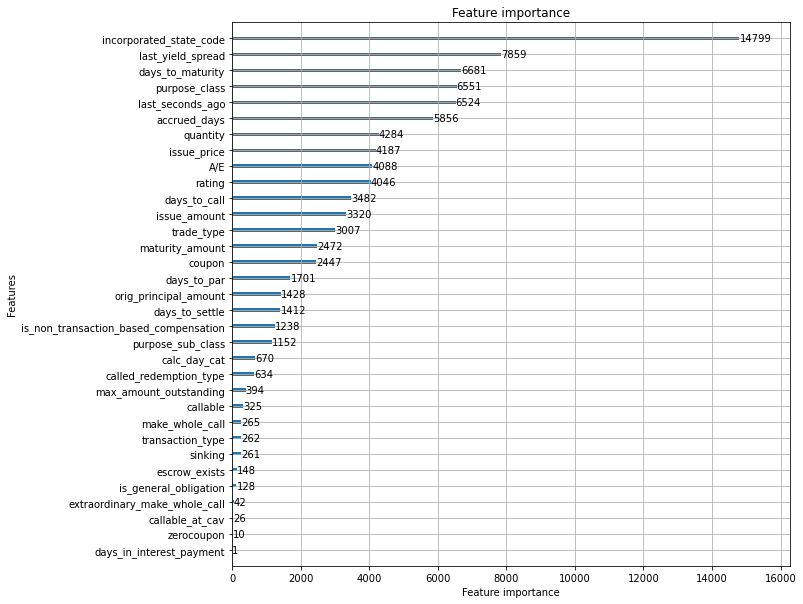

In [236]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10))